In [1]:
from pathlib import Path
from typing import Iterable, List, Optional, Callable
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm
import schedulefree
import segmentation_models_pytorch as smp
# from dvclive import Live
import torchseg
from flipnslide.tiling import FlipnSlide
from torchgeo.transforms import AugmentationSequential
from typing import Any
from torch import Tensor
import kornia as K

In [2]:
%load_ext watermark
%watermark -v -m --iversions

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

matplotlib                 : 3.5.2
segmentation_models_pytorch: 0.3.3
torchgeo                   : 0.5.2
torchseg                   : 0.0.1a4
schedulefree               : 1.2.7
rasterio                   : 1.3.10
kornia                     : 0.7.2
torch                      : 2.4.0.dev20240405+cu121



In [3]:
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

In [4]:
# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize= 64, viz=False)
tfms = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

In [5]:
# Example usage
train_batch = {
    'image': torch.rand(1, 11, 256, 256),
    'mask': torch.rand(1, 1, 256, 256),
    'crs': [],
    'bbox': []
}
batch_tfms = [tfms, tfms_img]
if batch_tfms is not None:
    transformed = [tfm(train_batch) for tfm in batch_tfms][0]
#transformed = tfms(tfms_img(train_batch))

print("Transformed image shape:", transformed['image'].shape)
print("Transformed mask shape:", transformed['mask'].shape)

Transformed image shape: torch.Size([58, 13, 64, 64])
Transformed mask shape: torch.Size([58, 64, 64])


# Visualise a single image

In [6]:
from pathlib import  Path
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN")
assert root.exists()

# train_imgs = list((root/'images').glob('*.tif'))
# train_masks = list((root/'masks').glob('*.tif'))
train_imgs = list((root/'X').glob('*.tif'))
train_masks = list((root/'Y').glob('*.tif'))

# As the images and corresponding masks are matched by name, we will sort both lists to keep them synchronized.
train_imgs.sort(); train_masks.sort()

In [7]:
idx = 11
img = rxr.open_rasterio(train_imgs[idx])
mask = rxr.open_rasterio(train_masks[idx])

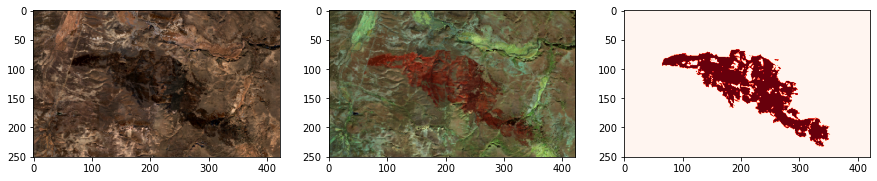

In [8]:
_, axs = plt.subplots(1, 3, figsize=(15, 6))

# plot the tile
FCI = [8, 6, 2]
TCI = [2, 1, 0]

rgb = img.data[TCI].transpose((1, 2, 0))*3#/17000
axs[0].imshow(rgb.clip(min=0, max=1))

rgb = img.data[FCI].transpose((1, 2, 0))*2#/25000
axs[1].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[2].imshow(mask.data.squeeze(), cmap='Reds')

In [10]:
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples

# train_ds = RasterDataset(paths=(root/'images').as_posix(), crs='epsg:4326', res= 0.00025)
train_ds = RasterDataset(paths=(root/'X').as_posix(), crs='epsg:4326', res= 0.00025)

In [11]:
from torchgeo.samplers import RandomGeoSampler
sampler = RandomGeoSampler(train_ds, size= 64, length= 100)

In [12]:
import torch 

# this is to get the same result in every pass
torch.manual_seed(0)

bbox = next(iter(sampler))
sample = train_ds[bbox]
print(sample.keys())
print(sample['image'].shape)

dict_keys(['crs', 'bbox', 'image'])
torch.Size([11, 64, 64])


c:\ProgramData\Anaconda3\envs\erthy\lib\site-packages\rasterio\merge.py:316: UserWarning: The nodata value, -inf, is beyond the valid range of the chosen data type, float32. Consider overriding it using the --nodata option for better results.
  warnings.warn(


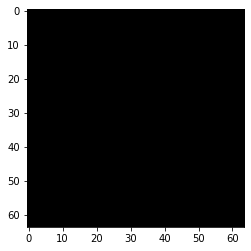

In [13]:
import torch
import matplotlib.pyplot as plt

arr = torch.clamp(sample['image'], min=0, max=1).numpy()
rgb = arr.transpose(2, 1, 0)[:, :, [8, 6, 2]]

plt.imshow(3*rgb.clip(min=0, max=1))

In [14]:
import logging
# this line is to avoid warnings from Rasterio to be printed on screen
# the warning is explained here: https://stackoverflow.com/questions/74089170/suppress-rasterio-warning-warning-1-tiffreaddirectory
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

# Creating the datasets

In [ ]:
import os
import shutil
import random
from tqdm.auto import tqdm

def split_data(root, image_folder, mask_folder, train_ratio=0.8, seed=None, fromRep=None, toRep=None):
    # Create train and test directories if they don't exist
    train_dir = os.path.join(root, 'train')
    test_dir = os.path.join(root, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Create image and mask folders within train and test directories
    train_image_dir = os.path.join(train_dir, 'images')
    train_mask_dir = os.path.join(train_dir, 'masks')
    test_image_dir = os.path.join(test_dir, 'images')
    test_mask_dir = os.path.join(test_dir, 'masks')
    os.makedirs(train_image_dir, exist_ok=True)
    os.makedirs(train_mask_dir, exist_ok=True)
    os.makedirs(test_image_dir, exist_ok=True)
    os.makedirs(test_mask_dir, exist_ok=True)

    # Get list of TIFF image filenames
    image_filenames = [filename for filename in os.listdir(os.path.join(root, image_folder)) if filename.endswith('.tif')]

    # Set random seed for reproducibility
    random.seed(seed)

    # Randomly shuffle filenames
    random.shuffle(image_filenames)

    # Calculate number of samples for train and test
    num_samples = len(image_filenames)
    num_train_samples = int(num_samples * train_ratio)
    num_test_samples = num_samples - num_train_samples

    # Split images into train and test sets
    train_images = image_filenames[:num_train_samples]
    test_images = image_filenames[num_train_samples:]

    # Move images and masks to train and test directories
    for image_name in tqdm(train_images, desc='Copying train images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.copy(image_path, os.path.join(train_image_dir, image_name))
            shutil.copy(mask_path, os.path.join(train_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    for image_name in tqdm(test_images, desc='Copying test images and masks'):
        image_path = os.path.join(root, image_folder, image_name)
        mask_name = image_name.replace(fromRep, toRep)
        mask_path = os.path.join(root, mask_folder, mask_name)
        if os.path.exists(image_path) and os.path.exists(mask_path):
            shutil.copy(image_path, os.path.join(test_image_dir, image_name))
            shutil.copy(mask_path, os.path.join(test_mask_dir, mask_name))
        else:
            print(f"Either image {image_name} or mask {mask_name} does not exist.")

    print("Data split completed. Train samples:", num_train_samples, "Test samples:", num_test_samples)

# Example usage
dirname = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN"
split_data(dirname, 'X', 'Y', train_ratio=0.8, seed=42, fromRep='image_', toRep='label_')


In [ ]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images"
process_images(directory)


In [6]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -2147483648] = 0
            
            # Update metadata
            profile = src.profile
            # profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\masks"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\masks"
process_images(directory)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [7]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np
import torch

def process_images(directory, num_classes):
    # List all files in the folder with a .tif extension
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        
        try:
            with rasterio.open(filepath) as src:
                # Read all bands data
                bands_data = src.read()
                
                # Assuming the target tensor is one of the bands or derived from the bands
                # Example: using the first band as the target tensor (customize as needed)
                target_tensor = torch.tensor(bands_data[0], dtype=torch.long)
                
                # Check if all values in the target tensor are within valid class indices
                if not torch.all((target_tensor >= 0) & (target_tensor < num_classes)):
                    print(f"Error: {filename} contains invalid class indices.")
                    print(target_tensor)
        
        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\masks"
process_images(directory, 2)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\masks"
process_images(directory, 2)


Processing images:   0%|          | 0/711 [00:00<?, ?it/s]

Processing images:   0%|          | 0/178 [00:00<?, ?it/s]

In [ ]:
# remove V.* bands
import os
import rasterio
from tqdm.auto import tqdm

def process_images(directory, delete=False):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Check for band names starting with 'V'
            band_names = src.descriptions
            bands_to_keep = [i + 1 for i, name in enumerate(band_names) if not name.startswith('V')]

            if not bands_to_keep:
                # If no bands to keep, skip or delete the image
                if delete:
                    src.close()
                    os.remove(filepath)
                    print(f"Deleted {filename} because it contains only 'V' bands.")
                else:
                    print(f"Skipped {filename} because it contains only 'V' bands.")
                continue

            if len(bands_to_keep) != len(band_names):
                # Read selected bands and metadata
                bands_data = [src.read(band) for band in bands_to_keep]
                profile = src.profile

        if bands_to_keep:
            # Update metadata
            profile.update(count=len(bands_to_keep))

            # Overwrite the image with the selected bands
            with rasterio.open(filepath, 'w', **profile) as dst:
                for idx, band_data in enumerate(bands_data, start=1):
                    dst.write(band_data, idx)
            print(f"Processed and updated {filename}.")

# Example usage
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\train\images"
process_images(directory, delete=False)
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\test\images"
# process_images(directory, delete=False)


# Visualise batch data

In [15]:
from pathlib import Path
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torch.utils.data import DataLoader

# root = Path(r"C:\Users\coach\myfiles\postdoc\Fire\data\indonesia\fire_data")
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()

train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False

In [16]:
sampler = RandomGeoSampler(train_imgs, size=256, length=30, units=Units.PIXELS)
# let's get a random bounding box, just to check the datasets
bbox = next(iter(sampler))

img_sample = train_imgs[bbox]
msk_sample = train_msks[bbox]

print(img_sample.keys(), msk_sample.keys())

# let's assert the patches cover the same region...
print(img_sample['bbox'])
print(msk_sample['bbox'])
assert img_sample['bbox'] == msk_sample['bbox']

dict_keys(['crs', 'bbox', 'image']) dict_keys(['crs', 'bbox', 'mask'])
BoundingBox(minx=-156.60214082431105, maxx=-156.53814082431106, miny=60.14105692416222, maxy=60.20505692416222, mint=0.0, maxt=9.223372036854776e+18)
BoundingBox(minx=-156.60214082431105, maxx=-156.53814082431106, miny=60.14105692416222, maxy=60.20505692416222, mint=0.0, maxt=9.223372036854776e+18)


In [17]:
train_dset = train_imgs & train_msks

In [18]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [19]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=8, collate_fn=stack_samples)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [20]:
from typing import Iterable, List
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 1.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Reds')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [8, 6, 2]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())
    
    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))  

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore
    
        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

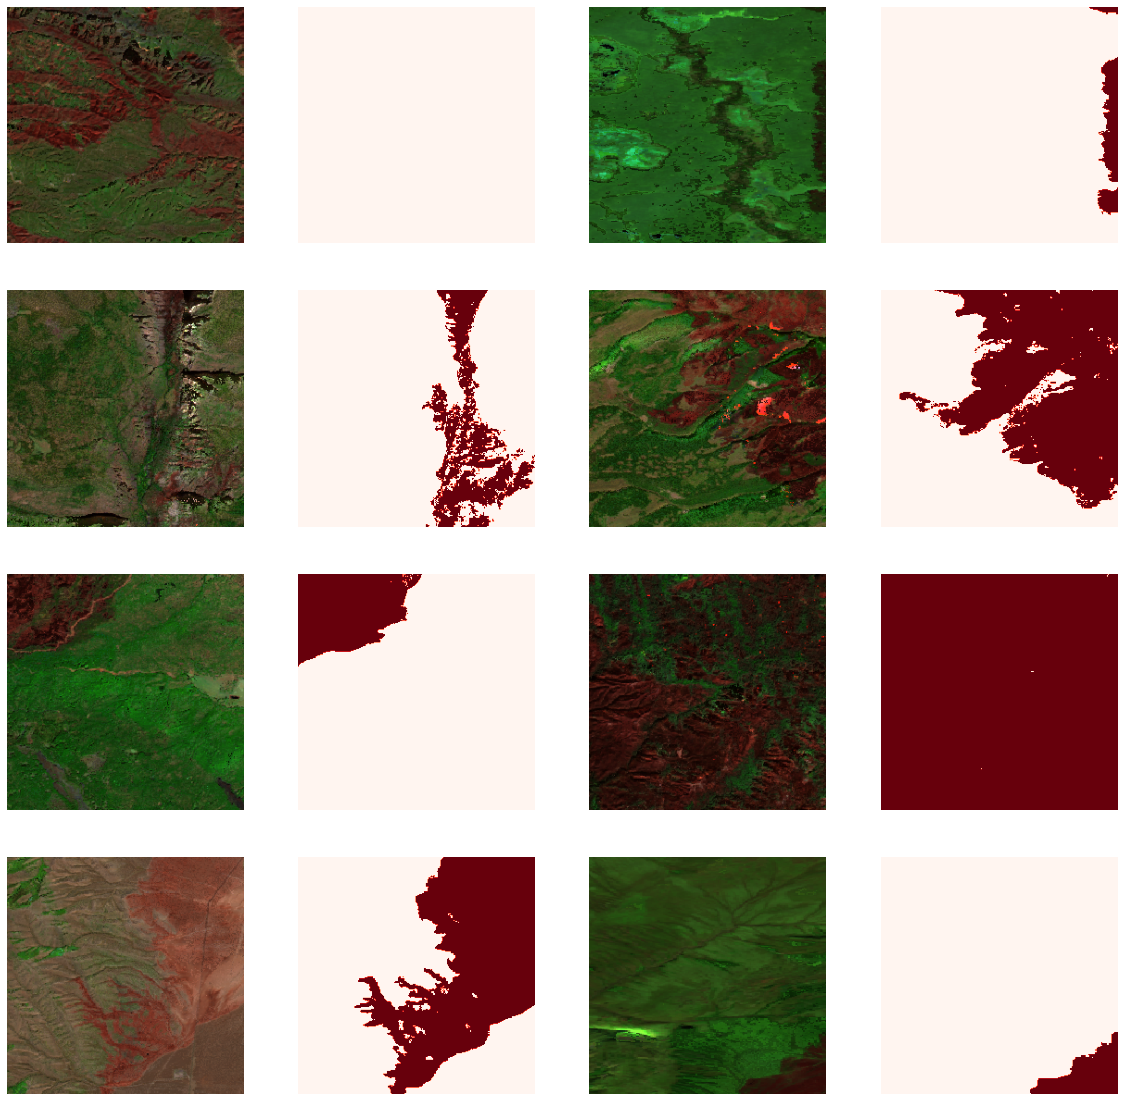

In [21]:
plot_batch(batch, 1.5)

In [22]:
from torchgeo.transforms import indices

ndwi_transform = indices.AppendNDWI(index_green=2, index_nir=4)

transformed_batch = ndwi_transform(batch['image'])
print(batch['image'].shape)
print(transformed_batch.shape)

torch.Size([8, 11, 256, 256])
torch.Size([8, 12, 256, 256])


In [23]:
import torch
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=64, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

dataloader = DataLoader(train_dset, sampler=sampler, batch_size=1, collate_fn=stack_samples)
batch = next(iter(dataloader))
print(batch.keys())
x = batch
print(x['image'].shape)
x = tfms_img(x)
print(x['image'].shape)

# print(tfms_both(x)['image'].shape)
x = tfms_fns(x)
print(x['mask'].unsqueeze(1).shape)

dict_keys(['crs', 'bbox', 'image', 'mask'])
torch.Size([1, 11, 256, 256])
torch.Size([1, 14, 256, 256])
torch.Size([58, 1, 64, 64])


In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [25]:
model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= 'imagenet',     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
)
model = model.to(device)

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

c:\ProgramData\Anaconda3\envs\erthy\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\coach\.cache\huggingface\hub\models--timm--convnextv2_tiny.fcmae_ft_in22k_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [26]:
pred = model(torch.randn(3, 14, 64, 64, device = device))
pred.shape

torch.Size([3, 2, 64, 64])

In [43]:
from typing import Dict 
import wandb

def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    batch_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")

        model.train()
        optimizer.train()
        accum_loss = 0
        
        with tqdm(total= len(train_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

            for batch in train_dl:
                if batch_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(batch_tfms, list):
                                batch = [tfm(batch) for tfm in batch_tfms][0]
                            else:
                                batch = batch_tfms(batch)

                X = batch['image'].to(device)
                y = batch['mask'].unsqueeze(1).type(torch.long).to(device)
                pred = model(torch.nan_to_num(X))
                loss = loss_fn(pred, y)

                # BackProp
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update the accum loss
                accum_loss += float(loss) / len(train_dl)
                
                pbar.set_postfix(loss=f"{accum_loss:.4f}")
                pbar.update(1)
        
        wandb.log({"train_loss": accum_loss})

        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                with tqdm(total= len(val_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

                    for batch in val_dl:

                        if batch_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(batch_tfms, list):
                                batch = [tfm(batch) for tfm in batch_tfms][0]
                            else:
                                batch = batch_tfms(batch)                    

                        X = batch['image'].type(torch.float32).to(device)
                        y = batch['mask'].unsqueeze(1).type(torch.long).to(device)

                        pred = model(torch.nan_to_num(X))
                        val_loss = loss_fn(pred, y)
                        accum_val_loss += float(val_loss)/len(val_dl)

                        for i, acc_fn in enumerate(acc_fns):
                            acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))
                        
                        pbar.set_postfix(val_loss=f"{accum_val_loss:.4f}", val_acc=f"{acc[0]:.4f}", val_iou=f"{acc[1]:.4f}")
                        pbar.update(1)

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.metric_index]
        chkpt_score = acc[i]
        if  chkpt_score > 0.7517:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.save_model_path)
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        wandb.log({"val_loss": accum_val_loss, "val_acc": acc[0], "val_iou": acc[1]})
    wandb.finish()

        # with Live(save_dvc_exp=True) as live:
        #     for param_name, param_value in train_params.items():
        #         live.log_param(param_name, param_value)
        #     live.log_metric("model_saving_score", chkpt_score)
        #     live.log_metric("Train loss", accum_loss)
        #     live.log_metric("Val_loss", accum_val_loss)

In [28]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [45]:
train_imgs = RasterDataset(paths=(root/'train\images').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\masks').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\images').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\masks').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

# from torchgeo.samplers import RandomBatchGeoSampler
# train_sampler = RandomBatchGeoSampler(train_dset, size = 64, batch_size= 10, length=1000)
# valid_sampler = RandomBatchGeoSampler(valid_dset, size = 64, batch_size= 10, length=1000)

# train_dataloader = DataLoader(train_dset, batch_sampler=train_sampler, collate_fn=stack_samples)
# valid_dataloader = DataLoader(valid_dset, batch_sampler=valid_sampler, collate_fn=stack_samples)


train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 711, units=Units.PIXELS)#711
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 178, units=Units.PIXELS)#178

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 1, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 1, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [ ]:
# Initialize wandb
wandb.init(project="burn_area_mapping", name="convnextv2", job_type='training p2')
# Define hyperparameters
config = wandb.config
config.learning_rate = 0.0025
config.epochs = 50
config.metric_index = 1
config.save_model_path = r"C:\Users\coach\myfiles\postdoc\Fire\models\Unet_imgnet_convnextT_28092024p2.pth"

loss_fn = smp.losses.LovaszLoss(mode= 'multiclass')
# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr= config.learning_rate)
train_loop(epochs = config.epochs, train_dl = train_dataloader, val_dl= valid_dataloader, model = model,
            loss_fn = loss_fn, optimizer = optimizer, 
            acc_fns=[oa, iou], batch_tfms= [tfms_img, tfms_fns], train_params = config)

# Plot predictions

In [47]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = smp.Unet(
#         encoder_name="resnet34",
#         encoder_weights= None,
#         in_channels=13,
#         classes=2,
#     ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")

model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\Unet_convnextT_27092024.pth")

model.load_state_dict(checkpoint)
model.eval()

Unet(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            

In [48]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\images').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\masks').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

In [49]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 5, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted (argmax)',  'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(out[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        # plot the reference mask
        axs[4].imshow(mask.squeeze(), cmap='Reds')
        axs[4].set_title(labels[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


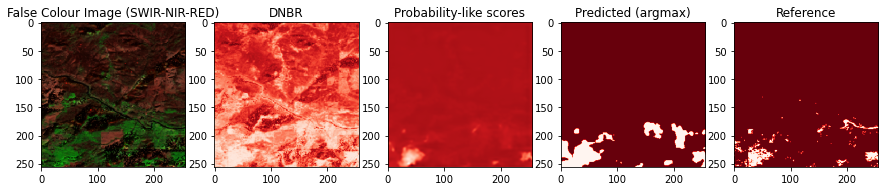

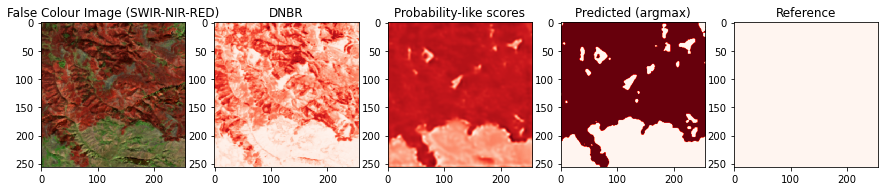

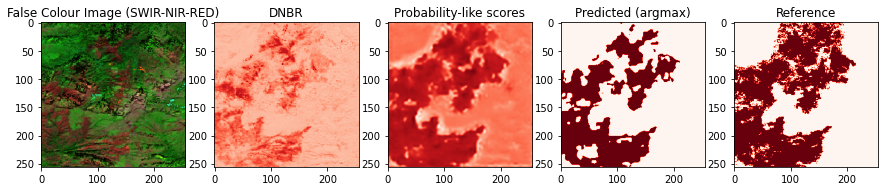

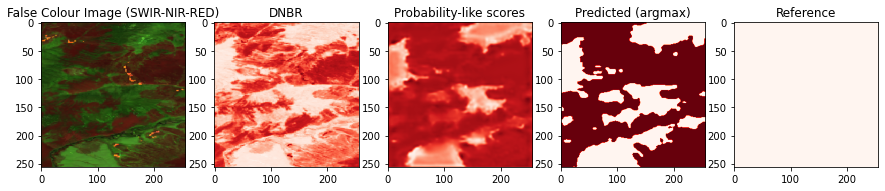

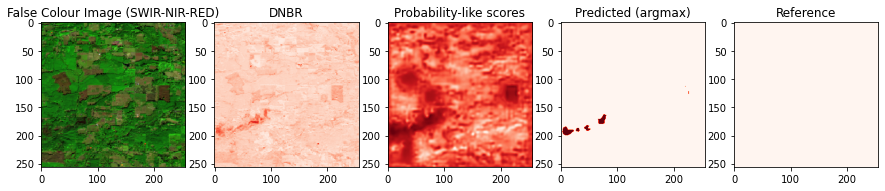

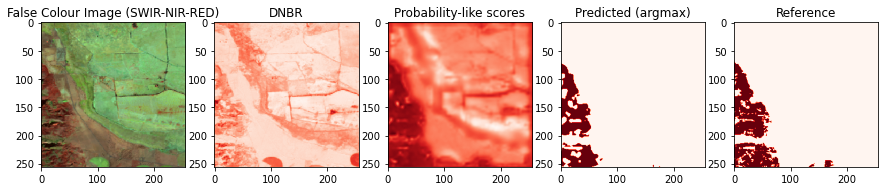

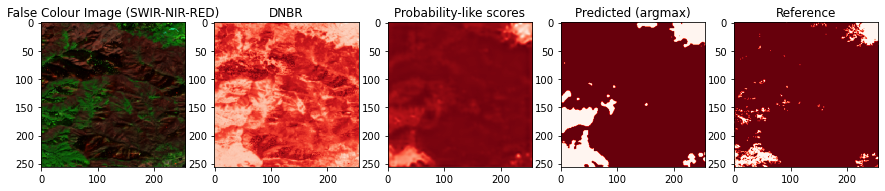

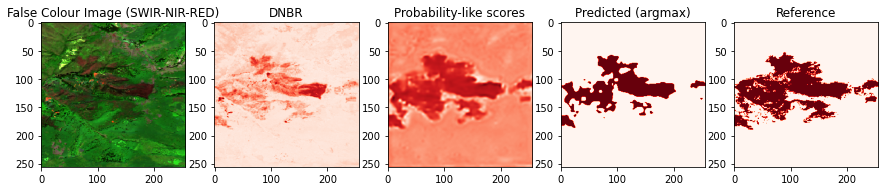

In [50]:
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(torch.nan_to_num(inB))
plot_batch_preds(batch)

# SA Data

In [ ]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\X"
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X"
process_images(directory)


In [51]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

modelunet = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")

modelunet.load_state_dict(checkpoint)
modelunet.eval()

model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")

model.load_state_dict(checkpoint)
model.eval()

modelnxt = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\Unet_imgnet_convnextT_28092024.pth")

modelnxt.load_state_dict(checkpoint)
modelnxt.eval()

Unet(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            

In [54]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
test_sampler = RandomGeoSampler(test_imgs, size= 128, length = 178, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_imgs, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


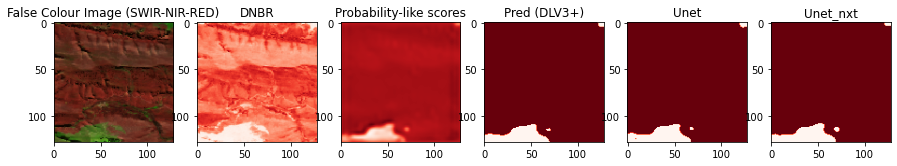

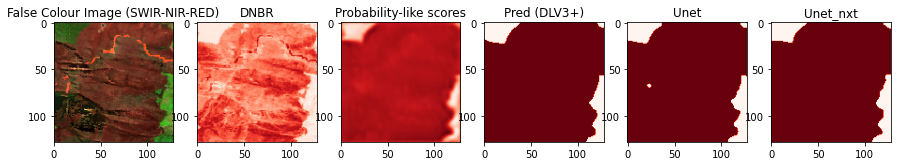

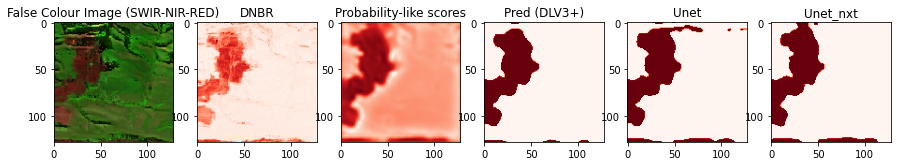

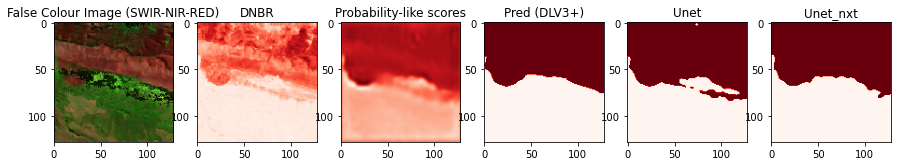

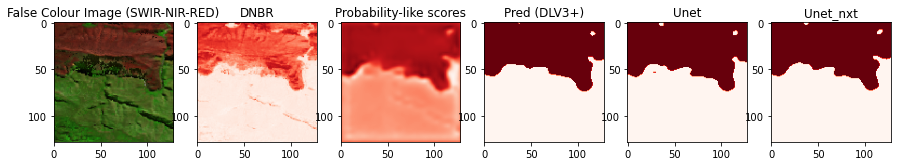

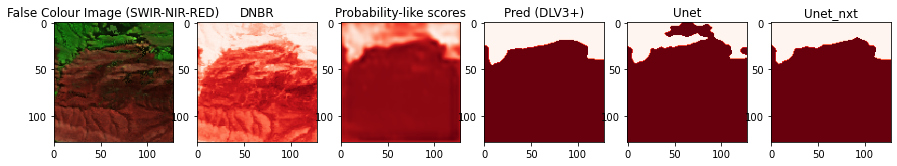

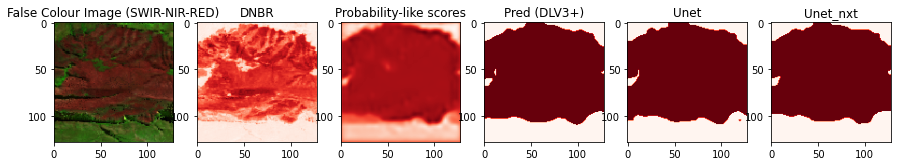

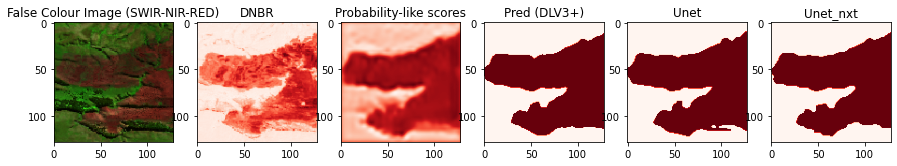

In [56]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 6, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Pred (DLV3+)',  'Unet', 'Unet_nxt']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
                
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(outnxt[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        pred_mask = np.argmax(outunet[idx].detach().cpu().numpy(), axis=0)
        axs[4].imshow(pred_mask, cmap='Reds')
        axs[4].set_title(labels[4])

        pred_mask = np.argmax(outnxt[idx].detach().cpu().numpy(), axis=0)
        axs[5].imshow(pred_mask, cmap='Reds')
        axs[5].set_title(labels[5])

batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)

out = model(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outunet = modelunet(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outnxt = modelnxt(inB)
plot_batch_preds(batch)

# Finetuning

In [1]:
# Prepare data
import os
import shutil
import rasterio
from tqdm.auto import tqdm
import random

def copy_projection_and_sort(
    masks_folder: str, 
    images_folder: str, 
    train_folder: str, 
    test_folder: str, 
    test_ratio: float = 0.2
) -> None:
    """
    Copies projection information from images in `images_folder` to matching masks in `masks_folder` 
    based on matching names after the first underscore. Then, copies both masks and images to 
    train or test folders.

    Args:
        masks_folder (str): Path to the folder containing mask TIFF files.
        images_folder (str): Path to the folder containing image TIFF files.
        train_folder (str): Path to the folder where train images and masks will be stored.
        test_folder (str): Path to the folder where test images and masks will be stored.
        test_ratio (float, optional): Proportion of files to copy to the test folder. Defaults to 0.2.
    """
    # Ensure train and test folders exist for both X (images) and Y (masks)
    os.makedirs(os.path.join(train_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'X'), exist_ok=True)
    os.makedirs(os.path.join(train_folder, 'Y'), exist_ok=True)
    os.makedirs(os.path.join(test_folder, 'Y'), exist_ok=True)

    # List all mask files in the masks folder
    mask_files = [f for f in os.listdir(masks_folder) if f.endswith('.tif')]
    
    # Randomize the order of files to ensure better train-test split
    random.shuffle(mask_files)
    
    for mask_file in tqdm(mask_files, desc="Processing masks"):
        # Get the part of the mask filename after the first underscore
        mask_id = mask_file.split('_', 1)[1]

        # Try to find the corresponding image in the images folder
        matching_images = [f for f in os.listdir(images_folder) if mask_id in f]
        if not matching_images:
            print(f"No matching image found for {mask_file}. Skipping...")
            continue

        image_file = matching_images[0]  # Assuming the first match is the correct one

        # Read the projection information from the image file
        image_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, mask_file)

        with rasterio.open(image_path) as src_image:
            image_crs = src_image.crs
            image_transform = src_image.transform

        # Copy the mask file with updated projection information
        with rasterio.open(mask_path, 'r+') as dst_mask:
            dst_mask.crs = image_crs
            dst_mask.transform = image_transform

        # Determine if the file goes into train or test set based on test_ratio
        if random.random() < test_ratio:
            dest_folder = test_folder
        else:
            dest_folder = train_folder

        # Copy both the mask and the corresponding image to the destination folder
        shutil.copy(mask_path, os.path.join(dest_folder, 'Y', mask_file))
        shutil.copy(image_path, os.path.join(dest_folder, 'X', image_file))


# Example usage:
maskPath = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\irisLabels"
imagePath = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\X_chips"
trainFolder = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train"
testFolder = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test"
copy_projection_and_sort(maskPath, imagePath, trainFolder, testFolder, 0.15)

Processing masks:   0%|          | 0/202 [00:00<?, ?it/s]

In [1]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from typing import Iterable, List, Optional, Callable

from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from dvclive import Live
import torchseg

import schedulefree


OSError: [WinError 1455] The paging file is too small for this operation to complete. Error loading "c:\ProgramData\Anaconda3\envs\erthy\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [3]:
from flipnslide.tiling import FlipnSlide
from typing import Any
from torch import Tensor
import kornia as K
from torchgeo.transforms import AugmentationSequential
class _FlipnSlide(K.augmentation.GeometricAugmentationBase2D):
    """Flip and slide a tensor."""

    def __init__(self, tilesize: int, viz: bool = False) -> None:
        """Initialize a new _FlipnSlide instance.

        Args:
            tilesize: desired tile size
            viz: visualization flag
        """
        super().__init__(same_on_batch = True, p=1)
        self.flags = {'tilesize': tilesize, 'viz': viz}

    def compute_transformation(
        self, input: Tensor, params: dict[str, Tensor], flags: dict[str, Any]
    ) -> Tensor:
        """Compute the transformation.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters

        Returns:
            the transformation
        """
        
        out: Tensor = self.identity_matrix(input)
        return out

    def apply_transform(
        self,
        input: Tensor,
        params: dict[str, Tensor],
        flags: dict[str, Any],
        transform: Tensor = None,
    ) -> Tensor:
        """Apply the transform.

        Args:
            input: the input tensor
            params: generated parameters
            flags: static parameters
            transform: the geometric transformation tensor

        Returns:
            the augmented input
        """
        np_array = input.squeeze(0).cpu().numpy()
        sample_tiled = FlipnSlide(
            tile_size=flags['tilesize'], 
            data_type='tensor',
            save=False, 
            image=np_array,
            viz=flags['viz']
        )
        return sample_tiled.tiles

# Usage with AugmentationSequential
flipnslide = _FlipnSlide(tilesize=128, viz=False)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
tfms_fns = AugmentationSequential(
    flipnslide,
    data_keys= ['image', 'mask']
)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
modelunet = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
modelunet.load_state_dict(checkpoint)

model = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")
model.load_state_dict(checkpoint)

model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\Unet_imgnet_convnextT_28092024.pth")

model.load_state_dict(checkpoint)
model.eval()

Unet(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            

In [5]:
from typing import Dict 
import wandb

def train_loop(
    epochs: int,
    train_dl: DataLoader, 
    val_dl: Optional[DataLoader], 
    model: torch.nn.Module, 
    loss_fn: Callable, 
    optimizer: torch.optim.Optimizer, 
    acc_fns: Optional[List]=None, 
    train_tfms: Optional[Callable]=None,
    val_tfms: Optional[Callable]=None,
    train_params: Dict=None
):
    best_chkpt_score = float("-inf")
    for epoch in range(1, epochs+1):
        print(f"\nEpoch {epoch}/{epochs}")

        model.train()
        optimizer.train()
        accum_loss = 0
        
        with tqdm(total= len(train_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

            for batch in train_dl:
                if train_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(train_tfms, list):
                                batch = [tfm(batch) for tfm in train_tfms][0]
                            else:
                                batch = train_tfms(batch)

                X = batch['image'].to(device)
                y = batch['mask'].unsqueeze(1).type(torch.long).to(device)
                pred = model(torch.nan_to_num(X))
                loss = loss_fn(pred, y)

                # BackProp
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # update the accum loss
                accum_loss += float(loss) / len(train_dl)
                
                pbar.set_postfix(loss=f"{accum_loss:.4f}")
                pbar.update(1)
        
        wandb.log({"train_loss": accum_loss})

        
        model.eval()
        optimizer.eval()
        accum_val_loss = 0
        # Testing against the validation dataset
        if acc_fns is not None and val_dl is not None:
            # reset the accuracies metrics
            acc = [0.] * len(acc_fns)

            with torch.no_grad():
                with tqdm(total= len(val_dl), ascii=True, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}{postfix}]") as pbar:

                    for batch in val_dl:

                        if val_tfms is not None:
                            # if multiple transforms, Apply transforms iteratively
                            if isinstance(val_tfms, list):
                                batch = [tfm(batch) for tfm in val_tfms][0]
                            else:
                                batch = val_tfms(batch)                    

                        X = batch['image'].type(torch.float32).to(device)
                        y = batch['mask'].unsqueeze(1).type(torch.long).to(device)

                        pred = model(torch.nan_to_num(X))
                        val_loss = loss_fn(pred, y)
                        accum_val_loss += float(val_loss)/len(val_dl)

                        for i, acc_fn in enumerate(acc_fns):
                            acc[i] = float(acc[i] + acc_fn(pred, y)/len(val_dl))
                        
                        pbar.set_postfix(val_loss=f"{accum_val_loss:.4f}", val_acc=f"{acc[0]:.4f}", val_iou=f"{acc[1]:.4f}")
                        pbar.update(1)

        # Check if validation loss improved
        acc_fn = acc_fns[train_params.metric_index]
        chkpt_score = acc[i]
        if  chkpt_score > best_chkpt_score:
            best_chkpt_score = chkpt_score
            torch.save(model.state_dict(), train_params.save_model_path)
            print(f'Saving model with validation score: {best_chkpt_score:.4f} at epoch {epoch}')

        wandb.log({"val_loss": accum_val_loss, "val_acc": acc[0], "val_iou": acc[1]})
    wandb.finish()

        # with Live(save_dvc_exp=True) as live:
        #     for param_name, param_value in train_params.items():
        #         live.log_param(param_name, param_value)
        #     live.log_metric("model_saving_score", chkpt_score)
        #     live.log_metric("Train loss", accum_loss)
        #     live.log_metric("Val_loss", accum_val_loss)

In [6]:
from sklearn.metrics import jaccard_score

def oa(pred, y):
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

def iou(pred, y):
    flat_y = y.cpu().numpy().squeeze()
    flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
    return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

def loss(p, t):    
    return torch.nn.functional.cross_entropy(p, t)

In [7]:
import os
from pathlib import Path

def compare_and_delete_tif_images(directory, delete_unmatched=False):
    # Get the paths for subdirectories X and Y
    x_path = Path(directory) / 'X'
    y_path = Path(directory) / 'Y'
    
    # Check if both subdirectories exist
    if not (x_path.is_dir() and y_path.is_dir()):
        raise ValueError("Both subdirectories X and Y must exist in the given directory.")
    
    # Get lists of .tif files in both directories
    x_files = set(f.name for f in x_path.glob('*.tif'))
    y_files = set(f.name for f in y_path.glob('*.tif'))
    
    # Function to get the matching part of the filename
    def get_matching_part(filename):
        return '_'.join(filename.split('_')[1:])
    
    # Create sets of matching parts for both directories
    x_matching_parts = set(get_matching_part(f) for f in x_files)
    y_matching_parts = set(get_matching_part(f) for f in y_files)
    
    # Find unmatched files
    unmatched_x = [f for f in x_files if get_matching_part(f) not in y_matching_parts]
    unmatched_y = [f for f in y_files if get_matching_part(f) not in x_matching_parts]
    
    # Delete unmatched files if delete_unmatched is True
    if delete_unmatched:
        for file in unmatched_x:
            (x_path / file).unlink()
        for file in unmatched_y:
            (y_path / file).unlink()
        print(f"Deleted {len(unmatched_x)} unmatched files from X and {len(unmatched_y)} unmatched files from Y.")
    
    return {
        'unmatched_in_X': unmatched_x,
        'unmatched_in_Y': unmatched_y
    }

# Example usage:
root_dir = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train'
compare_and_delete_tif_images(root_dir, True)

root_dir = r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test'
compare_and_delete_tif_images(root_dir, True)


Deleted 8 unmatched files from X and 17 unmatched files from Y.
Deleted 1 unmatched files from X and 1 unmatched files from Y.


{'unmatched_in_X': ['image_1005_0_0.tif'],
 'unmatched_in_Y': ['mask_5_0_0.tif']}

In [8]:
# replace -inf nan values with nan
import os
import rasterio
from tqdm.auto import tqdm
import numpy as np

def process_images(directory):
    # List all files in the folder
    tif_files = [f for f in os.listdir(directory) if f.endswith('.tif')]
    for filename in tqdm(tif_files, desc="Processing images"):
        filepath = os.path.join(directory, filename)
        with rasterio.open(filepath) as src:
            # Read all bands data
            bands_data = src.read()

            # Replace -inf with NaN
            bands_data[bands_data == -np.inf] = np.nan
            
            # Update metadata
            profile = src.profile
            profile.update(nodata= np.nan)

            # Save band descriptions
            band_descriptions = [src.descriptions[i] for i in range(src.count)]
            
        # Write the data with the updated profile
        with rasterio.open(filepath, 'w', **profile) as dst:
            dst.write(bands_data)
            # Set band descriptions
            for i, desc in enumerate(band_descriptions, start=1):
                dst.set_band_description(i, desc)

        # print(f"Processed and updated {filename}.")

# Example usage
# directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\DNN\X_test"
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\test\X"
process_images(directory)
directory = r"C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2\train\X"
process_images(directory)

Processing images:   0%|          | 0/378 [00:00<?, ?it/s]

Processing images:   0%|          | 0/210 [00:00<?, ?it/s]

In [9]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2')
assert root.exists()
train_imgs = RasterDataset(paths=(root/'train\X').as_posix(), crs='epsg:4326', res= 0.00025)
train_msks = RasterDataset(paths=(root/'train\Y').as_posix(), crs='epsg:4326', res= 0.00025)

valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)

# IMPORTANT
train_msks.is_image = False
valid_msks.is_image = False

train_dset = train_imgs & train_msks
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size= 256, length = 210, units=Units.PIXELS)#667#168
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 378, units=Units.PIXELS)#287#34

train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size = 1, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 1, collate_fn=stack_samples)

train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
train_batch.keys(), valid_batch.keys()

(dict_keys(['crs', 'bbox', 'image', 'mask']),
 dict_keys(['crs', 'bbox', 'image', 'mask']))

In [10]:
# Initialize wandb
wandb.init(project="burn_area_mapping", name="convnextv2_wCoastal_wAgric_subset")
# Define hyperparameters
config = wandb.config
config.learning_rate = 0.0025
config.epochs = 100
config.metric_index = 1
config.save_model_path = r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_16102024.pth"

loss_fn = smp.losses.LovaszLoss(mode= 'multiclass')
# optimizer = torch.optim.Adam(model.parameters(), lr= train_params.get('lr'), weight_decay= train_params.get('weight_decay'))
optimizer = schedulefree.AdamWScheduleFree(model.parameters(), lr= config.learning_rate)

# Freeze encoder weights
for param in model.encoder.parameters():
    param.requires_grad = False

# Check if the encoder parameters are frozen
# for name, param in model.encoder.named_parameters():
#     print(f"{name} requires_grad: {param.requires_grad}")

train_loop(epochs = config.epochs, train_dl = train_dataloader, val_dl= valid_dataloader, model = model,
            loss_fn = loss_fn, optimizer = optimizer, 
            acc_fns=[oa, iou], train_tfms= [tfms_img, tfms_fns], val_tfms = tfms_img, train_params = config)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: singhg10. Use `wandb login --relogin` to force relogin



Epoch 1/100


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

Saving model with validation score: 0.7718 at epoch 1

Epoch 2/100


  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/378 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
import torchseg
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUNet_12092024.pth")
model.load_state_dict(checkpoint)
model.eval()

modelus = smp.Unet(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\UNet_16082024.pth")
modelus.load_state_dict(checkpoint)
modelus.eval()

modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FT2DLV3P_27092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

modeldlus = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\DLV3P_12092024.pth")
modeldlus.load_state_dict(checkpoint)
modeldlus.eval()

modelnxt = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_29092024.pth")

modelnxt.load_state_dict(checkpoint)
modelnxt.eval()

modelnxtft = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

# checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_convnextT_28092024.pth")
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_16102024.pth")


modelnxtft.load_state_dict(checkpoint)
modelnxtft.eval()

NameError: name 'torch' is not defined

In [12]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
# valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)
root2 = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel')
valid_msks = RasterDataset(paths=(root2/'altY_chips').as_posix(), crs='epsg:4326', res= 0.00025)


# valid_imgs = RasterDataset(paths=(root/'train\X').as_posix(), crs='epsg:4326', res= 0.00025)
# valid_msks = RasterDataset(paths=(root/'train\Y').as_posix(), crs='epsg:4326', res= 0.00025)
valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 256, length = 78, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

In [13]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(2, 6, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Pred (UNet)', 'Pred (UNet) FT','Pred (DLV3+)', 'Pred (DLV3+) FT',  'pred (Unet)', 'pred (Unet FT)', 'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
        mask = batch['mask'][idx].cpu().numpy()
        
        rgb = img.transpose((1, 2, 0))
        axs[0, 0].imshow(rgb)
        # plot the tile
        axs[0, 0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[0, 1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[0, 1].set_title(labels[1])

        # plot the predicted mask
        axs[0, 2].imshow(outnxt[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[0, 2].set_title(labels[2])

        pred_mask = np.argmax(outus[idx].detach().cpu().numpy(), axis=0)
        axs[1,0].imshow(pred_mask, cmap='Reds')
        axs[1,0].set_title(labels[3])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[1,1].imshow(pred_mask, cmap='Reds')
        axs[1,1].set_title(labels[4])

        pred_mask = np.argmax(outdlus[idx].detach().cpu().numpy(), axis=0)
        axs[1,2].imshow(pred_mask, cmap='Reds')
        axs[1,2].set_title(labels[5])

        pred_mask = np.argmax(outdlft[idx].detach().cpu().numpy(), axis=0)
        axs[1,3].imshow(pred_mask, cmap='Reds')
        axs[1,3].set_title(labels[6])

        pred_mask = np.argmax(outnxt[idx].detach().cpu().numpy(), axis=0)
        axs[1,4].imshow(pred_mask, cmap='Reds')
        axs[1,4].set_title(labels[7])

        pred_mask = np.argmax(outnxtft[idx].detach().cpu().numpy(), axis=0)
        axs[1,5].imshow(pred_mask, cmap='Reds')
        axs[1,5].set_title(labels[8])

        # plot the reference mask
        axs[0,3].imshow(mask.squeeze(), cmap='Reds')
        axs[0,3].set_title(labels[9])

In [14]:
batch = next(iter(valid_dataloader))
inB = torch.nan_to_num(tfms_img(batch)['image']).to(device)
out = model(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outus = modelus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlft = modeldlft(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlus = modeldlus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outnxt = modelnxt(inB)
outnxtft = modelnxtft(inB)
plot_batch_preds(batch)

IndexError: query: BoundingBox(minx=20.51656407139244, maxx=20.58056407139244, miny=-34.39629433129078, maxy=-34.33229433129078, mint=0.0, maxt=9.223372036854776e+18) not found in index with bounds: BoundingBox(minx=17.296970964192976, maxx=32.889388676769165, miny=-34.3530137691851, maxy=-23.93462259855212, mint=0.0, maxt=9.223372036854776e+18)

In [18]:
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(test_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outus = modelus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlft = modeldlft(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outdlus = modeldlus(inB[:, torch.arange(inB.shape[1]) != 11, :, :])
outnxt = modelnxt(inB)
outnxtft = modelnxtft(inB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


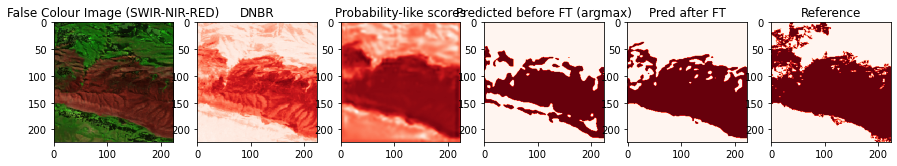

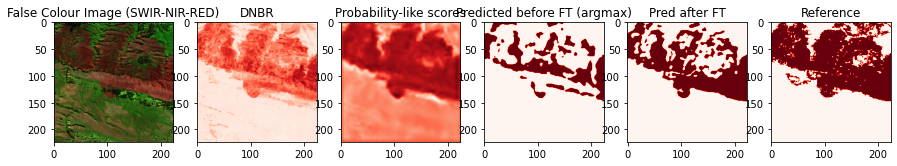

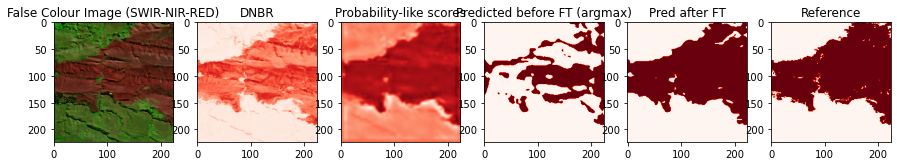

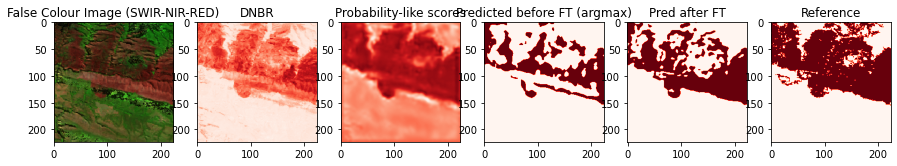

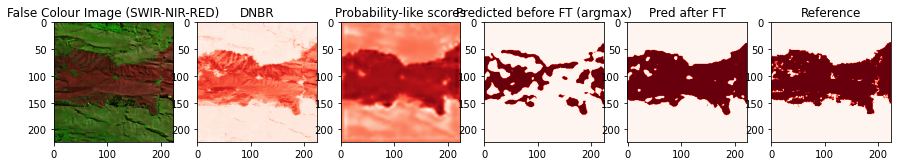

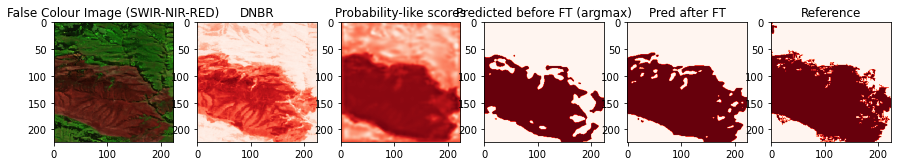

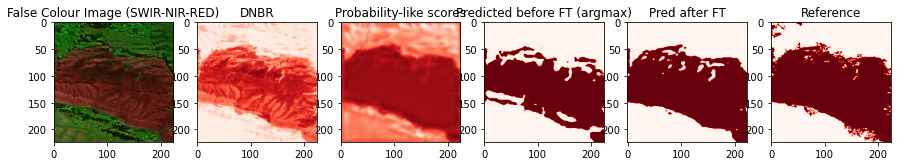

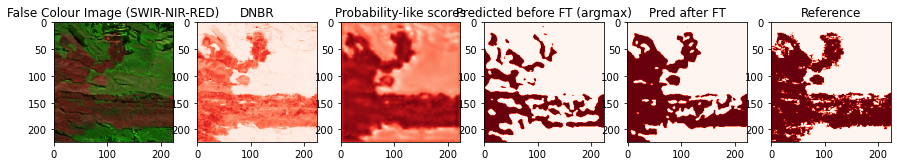

In [19]:
def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 6, figsize=(15, 6))

        # Define the labels
        labels = ['False Colour Image (SWIR-NIR-RED)', 'DNBR', 'Probability-like scores','Predicted before FT (argmax)',  'Pred after FT', 'Reference']

        inBatch = batch['image']
        img = inBatch[idx,[8, 6, 2],:,:].cpu().numpy()*2
                
        rgb = img.transpose((1, 2, 0))
        axs[0].imshow(rgb)
        # plot the tile
        axs[0].set_title(labels[0])

        dnbr = inBatch[idx,10,:,:].cpu().numpy()*2
        axs[1].imshow(dnbr, cmap = 'Reds')
        # plot the tile
        axs[1].set_title(labels[1])

        # plot the predicted mask
        axs[2].imshow(outnxt[idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[2].set_title(labels[2])

        pred_mask = np.argmax(outnxtft[idx].detach().cpu().numpy(), axis=0)
        axs[3].imshow(pred_mask, cmap='Reds')
        axs[3].set_title(labels[3])

        pred_mask = np.argmax(out[idx].detach().cpu().numpy(), axis=0)
        axs[4].imshow(pred_mask, cmap='Reds')
        axs[4].set_title(labels[4])

        mask = batch['mask'][idx].cpu().numpy()
        # plot the reference mask
        axs[5].imshow(mask.squeeze(), cmap='Reds')
        axs[5].set_title(labels[5])

plot_batch_preds(batch)

# Conformal prediction

In [20]:
# Conformal prediction

# Calibration - compute threshold
# compute adjusted quantile
# for each batch of images and masks, compute the adjusted quantile and append to list
# compute quantile for list

# Inference - compute set lengths and binary image for each class
# binarise probability bands based on threshold. compute sum of binary bands for set length

# Evaluation - compute RCPS, coverage and average set size
# check if the mask values are included in the binary images to compute coverage
# calculate mean of set length bands across all batches for average set size

import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from pathlib import Path
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torchgeo.transforms import AugmentationSequential
import numpy as np
import matplotlib.pyplot as plt
import torchseg

device = 'cuda' if torch.cuda.is_available() else 'cpu'

root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\toLabel\ft2')
assert root.exists()
valid_imgs = RasterDataset(paths=(root/'test\X').as_posix(), crs='epsg:4326', res= 0.00025)
valid_msks = RasterDataset(paths=(root/'test\Y').as_posix(), crs='epsg:4326', res= 0.00025)

valid_dset = valid_imgs & valid_msks

# IMPORTANT
valid_msks.is_image = False
valid_sampler = RandomGeoSampler(valid_imgs, size= 224, length = 78, units=Units.PIXELS)#287

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)

model = torchseg.Unet(
    encoder_name="convnextv2_tiny",        
    encoder_weights= None,     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=14,
    classes=2,
    encoder_depth= 4,
    decoder_channels=(256, 128, 64, 32),
    head_upsampling=2                      
).to(device)

checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTUnet_imgnet_convnextT_16102024.pth")#2909

model.load_state_dict(checkpoint)
model.eval()

Unet(
  (encoder): TimmEncoder(
    (model): FeatureListNet(
      (stem_0): Conv2d(14, 96, kernel_size=(4, 4), stride=(4, 4))
      (stem_1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      (stages_0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            

In [ ]:
X = next(iter(valid_dataloader))
outputs = model(torch.nan_to_num(tfms_img(X)['image'].to(device)))

probs = torch.softmax(outputs, dim=1)

# mask is 8, 1, 224, 224
# pred is 8, 2, 224, 224

In [21]:
import torch
import math
import numpy as np
from tqdm.auto import tqdm

# Calibration function to compute adjusted quantile
def compute_adjusted_quantile(n_cal, alpha):
    return 1 - (math.ceil((n_cal + 1) * (1 - alpha)) / n_cal)

# Calibration routine
def calibration(model, cal_loader, n_cal, alpha=0.1):
    adj_quantile = compute_adjusted_quantile(n_cal, alpha)
    print(f'Adjusted quantile: {adj_quantile}')
    
    scores = []
    with torch.no_grad():
        for batch in tqdm(cal_loader):
            X = tfms_img(batch)['image'].to(device)
            y = batch['mask'].type(torch.long).unsqueeze(1).to(device)
            
            # Get model outputs
            outputs = model(torch.nan_to_num(X))
            probs = torch.softmax(outputs, dim=1)
            
            # Select non-conformity scores corresponding to the true labels
            selected_scores = torch.gather(probs, 1, y)  # shape: (8, 1, 224, 244)
            
            # Calculate quantile on the flattened selected scores
            qhat = torch.quantile(selected_scores.flatten(), adj_quantile)
            # print(f"qhat for batch is {qhat}")
            
            # Store qhat in scores
            scores.append(qhat.cpu().numpy())  # move to CPU and convert to NumPy
            
    # Concatenate scores into a single array
    scores = np.array(scores)
    
    # Compute the final threshold using the adjusted quantile
    threshold = np.quantile(scores, adj_quantile)
    return threshold

# Inference
def inference(model, batch, threshold):
    
    with torch.no_grad():
        X = tfms_img(batch)['image'].type(torch.float32).to(device)
        outputs = model(torch.nan_to_num(X))
        probs = torch.softmax(outputs, dim=1)
        binary = (probs >= threshold).float()
        set_length = binary.sum(dim=1)
        batch['probability'] = outputs
        batch['pred'] = np.argmax(outputs.detach().cpu().numpy(), axis=1)
        batch['setLength'] = set_length
        batch['binary'] = binary
    return batch


# Evaluation
def evaluate(model, dataloader, threshold):
    coverages = []
    set_size = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            X = tfms_img(batch)['image'].to(device)
            y = batch['mask'].type(torch.long).unsqueeze(1).to(device)
                
            # Get model outputs
            outputs = model(torch.nan_to_num(X))
            probs = torch.softmax(outputs, dim=1)
            binary = (probs >= threshold).float()
            set_length = binary.sum(dim=1)

            coverage =  torch.gather(binary, 1, y).mean()
            coverages.append(coverage.cpu().numpy())
            avg_set_size = set_length.float().mean()
            set_size.append(avg_set_size.cpu().numpy())

    # Concatenate scores into a single array
    marginal_coverage = np.array(coverages).mean()
    average_set_sizes = np.array(set_size).mean()
    
    return {'coverage':marginal_coverage, 'set_size':average_set_sizes}

In [23]:
alpha = 0.95
compute_adjusted_quantile(2228224, 0.1)
threshold = calibration(model = model, cal_loader = valid_dataloader, n_cal = 2228224, alpha = 0.1)
print(f"final qhat: {threshold}")
eval_metrics = evaluate(model, valid_dataloader, threshold)
print(eval_metrics)

Adjusted quantile: 0.09999937169692097


  0%|          | 0/10 [00:00<?, ?it/s]

final qhat: 0.9999998092610921


  0%|          | 0/10 [00:00<?, ?it/s]

{'coverage': 0.96646154, 'set_size': 0.984378}


In [24]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_batch_preds(batch):
    for idx in range(0, 8):
        _, axs = plt.subplots(1, 6, figsize=(20, 5))

        # Define the labels
        labels = ['FCI (SWIR-NIR-Red)', 'Mask', 'Uncertainty: Set length', 'Sets w/ BA', 'Prob', 'Pred']

        img = batch['image'][idx,[8, 6, 2],:,:].cpu().numpy()*2                
        fci = img.transpose((1, 2, 0))
        
        # plot the image
        axs[0].imshow(fci.squeeze())
        axs[0].set_title(labels[0])

        # plot the mask
        axs[1].imshow(batch['mask'][idx,:,:].cpu().numpy().squeeze(), cmap='Reds')
        axs[1].set_title(labels[1])

        # Create a discrete palette for set length
        cmap = ListedColormap(['red', 'orange', 'yellow'])
        axs[2].imshow(batch['setLength'][idx,:,:].cpu().numpy(), cmap=cmap, vmin=0, vmax=2)
        axs[2].set_title(labels[2])

        # Add a legend for the discrete palette
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=2), cmap=cmap), ax=axs[2], shrink=0.5)
        cbar.set_ticks([0.33, 1, 1.67])
        cbar.set_ticklabels(['0', '1', '2'])

        # plot the predicted mask
        axs[3].imshow(batch['binary'][idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[3].set_title(labels[3])

        # plot the probability band
        axs[4].imshow(batch['probability'][idx,1,:,:].detach().cpu().numpy().squeeze(), cmap='Reds')
        axs[4].set_title(labels[4])

        axs[5].imshow(batch['pred'][idx], cmap='Reds')
        axs[5].set_title(labels[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


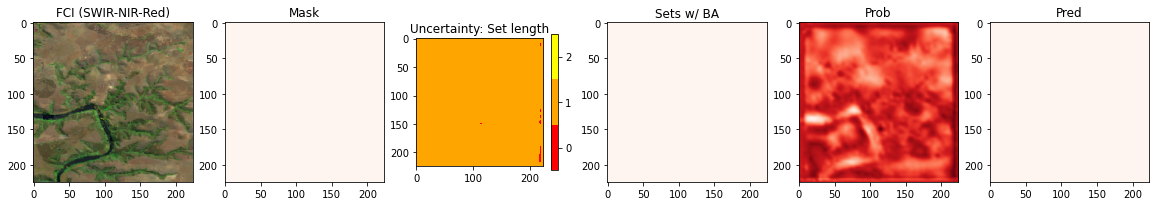

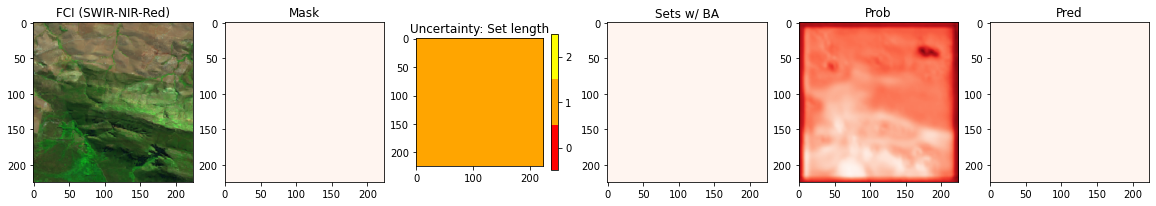

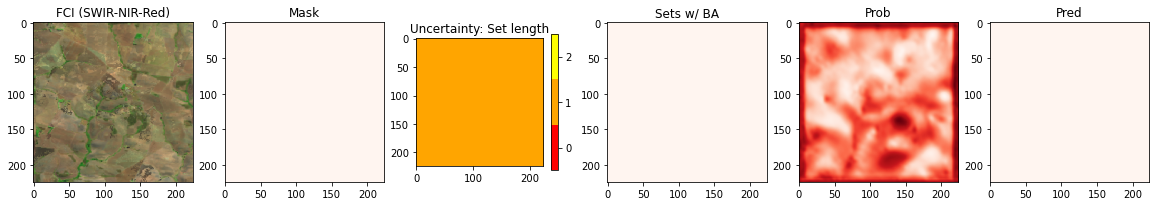

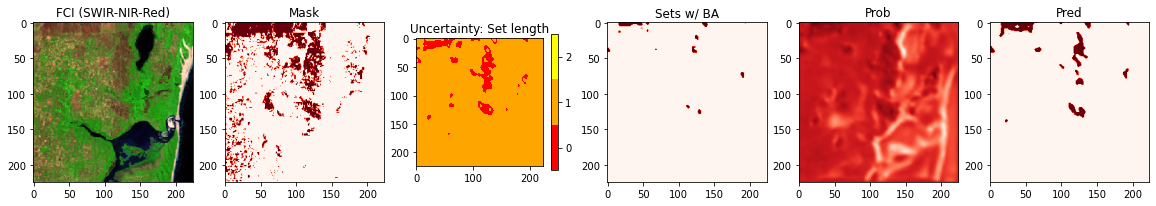

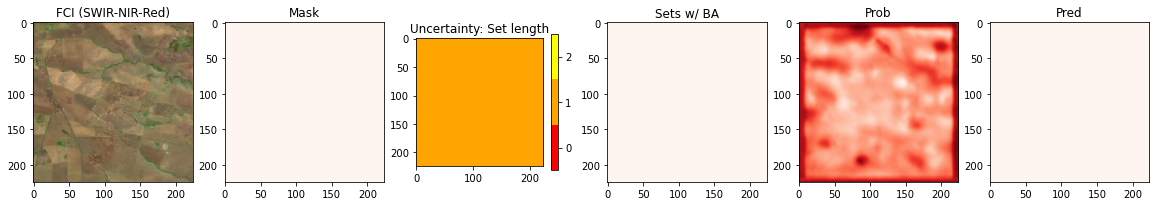

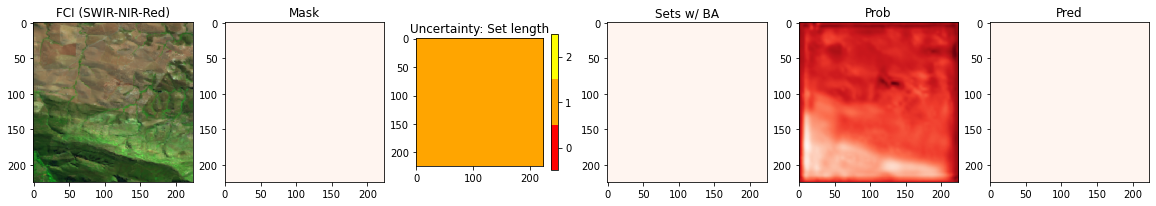

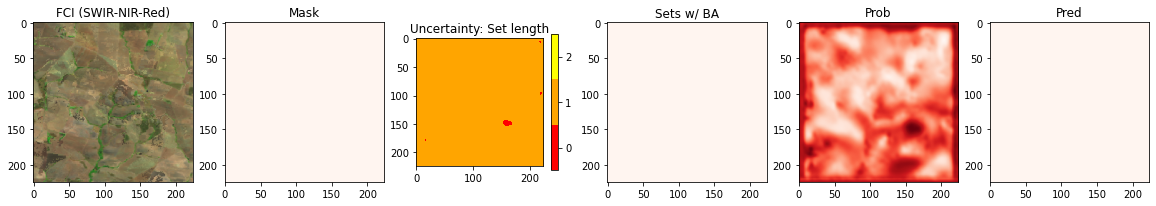

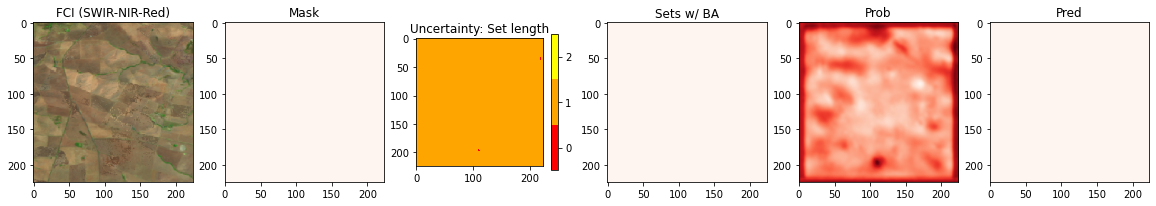

In [25]:
batch = next(iter(valid_dataloader))
uq = inference(model, batch, threshold)
plot_batch_preds(uq)

In [120]:
from torchcp.classification.scores import THR, SAPS
from torchcp.classification.predictors import SplitPredictor

# Preparing a calibration data and a test data.
# cal_dataloader = ...
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDBI(index_swir=8, index_nir=9),
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Preparing a pytorch model
modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

# Options of score function: THR, APS, SAPS, RAPS
# Define a conformal prediction algorithm. Optional: SplitPredictor, ClusteredPredictor, ClassWisePredictor
predictor = SplitPredictor(score_function=THR(), model=modeldlft)

# Calibrating the predictor with significance level as 0.1
predictor.calibrate(test_dataloader, alpha=0.1)

#########################################
# Predicting for test instances
########################################
# test_instances = ...
# predict_sets = predictor.predict(test_instances)
# print(predict_sets)

#########################################
# Evaluating the coverage rate and average set size on a given dataset.
########################################
# result_dict = predictor.evaluate(test_dataloader)
# print(result_dict["Coverage_rate"], result_dict["Average_size"])


AttributeError: 'list' object has no attribute 'to'

In [1]:
import torch
from scipy.optimize import brentq

def false_negative_rate(pred_masks, true_masks):
    # Ensure the inputs are binary tensors
    pred_masks = pred_masks.float()  # Convert to float for arithmetic operations
    true_masks = true_masks.float()
    
    # True positives: pixels correctly predicted as part of the object
    true_positives = (pred_masks * true_masks).sum(dim=[1, 2])
    
    # Total object pixels in the ground truth (true positives + false negatives)
    total_object_pixels = true_masks.sum(dim=[1, 2])
    
    # True Positive Rate (TPR) = true_positives / total_object_pixels
    tpr = true_positives / total_object_pixels
    
    # False Negative Rate (FNR) = 1 - TPR
    fnr = 1 - tpr
    
    # Return the average FNR across the batch
    return fnr.mean()

# Helper function to compute FNR for a given threshold
def lamhat_threshold(lam, calibration_loader, n, alpha, device):
    total_fnr = 0.0
    num_batches = 0
    
    for cal_sgmd, cal_gt_masks in calibration_loader:
        # Move data to the appropriate device (CPU/GPU)
        cal_sgmd = cal_sgmd.to(device)
        cal_gt_masks = cal_gt_masks.to(device)
        
        # Apply the threshold to the sigmoid outputs
        pred_masks = cal_sgmd >= lam
        
        # Calculate FNR for the current batch
        batch_fnr = false_negative_rate(pred_masks, cal_gt_masks)
        total_fnr += batch_fnr.item()
        num_batches += 1
    
    # Average FNR across all batches
    avg_fnr = total_fnr / num_batches
    
    # Return the difference between FNR and the target FNR
    return avg_fnr - ((n + 1) / n * alpha - 1 / n)

def find_lamhat(calibration_loader, n, alpha, device='cpu'):
    # Define the function to optimize (find the root)
    def threshold_func(lam):
        return lamhat_threshold(lam, calibration_loader, n, alpha, device)
    
    # Use Brent's method to find the optimal threshold `lamhat`
    lamhat = brentq(threshold_func, 0, 1)
    
    return lamhat

def predict_masks(val_loader, lamhat, device='cpu'):
    predicted_masks_list = []
    
    for val_sgmd, _ in val_loader:
        # Move data to the appropriate device
        val_sgmd = val_sgmd.to(device)
        
        # Apply the threshold to sigmoid outputs
        predicted_masks = val_sgmd >= lamhat
        
        # Collect the predicted masks
        predicted_masks_list.append(predicted_masks.cpu())  # Move back to CPU if needed
    
    # Concatenate all predicted masks into a single tensor
    return torch.cat(predicted_masks_list, dim=0)


In [ ]:
# Preparing a calibration data and a test data.
# cal_dataloader = ...
root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Preparing a pytorch model
modeldlft = smp.DeepLabV3Plus(
        encoder_name="resnet34",
        encoder_weights= None,
        in_channels=13,
        classes=2,
    ).to(device)
# r"C:\Users\coach\myfiles\postdoc\Fire\code\Burn_Area_Mapping\src\components\artifacts\segModel_22042024.pth"
checkpoint = torch.load(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth")
modeldlft.load_state_dict(checkpoint)
modeldlft.eval()

In [ ]:
# Example setup for calibration and validation data loaders

# Number of calibration samples and desired alpha level
n = 10
alpha = 0.05

# Device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Find the optimal threshold `lamhat`
lamhat = find_lamhat(test_dataloader, n, alpha, device)

# Use `lamhat` to generate predictions for the validation set
predicted_masks = predict_masks(test_dataloader, lamhat, device)


In [ ]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
from scipy.optimize import brentq

# UNet model loading
def load_trained_unet_model(model_path, device='cpu'):
    model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_weights= None, classes=2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

from torch.nn.functional import softmax

valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size = 8, collate_fn=stack_samples)
batch = next(iter(valid_dataloader))
inB = tfms_img(batch)['image'].to(device)
out = model(inB)
outus = modelus(inB)
outdlft = modeldlft(inB)
outdlus = modeldlus(inB)
# test the functions
x = out[0, :, 0, 0]  # single pixel value

print("Softmax:", softmax(x, dim=0))
print(softmax(out, dim=1)[0, :, 0, 0])

# Sigmoid outputs
def get_softmax_outputs(model, data_loader, device='cpu'):
    all_softmax_outputs = []
    all_gt_masks = []
    
    with torch.no_grad():
        for images, gt_masks in data_loader:
            images = images.to(device)
            gt_masks = gt_masks.to(device)
            logits = model(images)
            sigmoids = torch.sigmoid(logits)
            all_softmax_outputs.append(sigmoids.cpu())
            all_gt_masks.append(gt_masks.cpu())
    return torch.cat(all_softmax_outputs, dim=0), torch.cat(all_gt_masks, dim=0)

# Define false negative rate calculation
def false_negative_rate(pred_masks, true_masks):
    pred_masks = pred_masks.float()
    true_masks = true_masks.float()
    true_positives = (pred_masks * true_masks).sum(dim=[1, 2])
    total_object_pixels = true_masks.sum(dim=[1, 2])
    tpr = true_positives / total_object_pixels
    fnr = 1 - tpr
    return fnr.mean()

# Find lamhat using calibration set
def lamhat_threshold(lam, calibration_loader, n, alpha, device):
    total_fnr = 0.0
    num_batches = 0
    for cal_sgmd, cal_gt_masks in calibration_loader:
        cal_sgmd = cal_sgmd.to(device)
        cal_gt_masks = cal_gt_masks.to(device)
        pred_masks = cal_sgmd >= lam
        batch_fnr = false_negative_rate(pred_masks, cal_gt_masks)
        total_fnr += batch_fnr.item()
        num_batches += 1
    avg_fnr = total_fnr / num_batches
    return avg_fnr - ((n + 1) / n * alpha - 1 / n)

def find_lamhat(calibration_loader, n, alpha, device='cpu'):
    def threshold_func(lam):
        return lamhat_threshold(lam, calibration_loader, n, alpha, device)
    lamhat = brentq(threshold_func, 0, 1)
    return lamhat

# Predict masks for validation set
def predict_masks(val_loader, lamhat, device='cpu'):
    predicted_masks_list = []
    for val_sgmd, _ in val_loader:
        val_sgmd = val_sgmd.to(device)
        predicted_masks = val_sgmd >= lamhat
        predicted_masks_list.append(predicted_masks.cpu())
    return torch.cat(predicted_masks_list, dim=0)

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_trained_unet_model(r"C:\Users\coach\myfiles\postdoc\Fire\models\FTDLV3P_12092024.pth", device)

root = Path(r'C:\Users\coach\myfiles\postdoc\Fire\data\DNN')
assert root.exists()
test_imgs = RasterDataset(paths=(root/'X_test').as_posix(), crs='epsg:4326', res= 0.00025)
test_masks = RasterDataset(paths=(root/'Y_test').as_posix(), crs='epsg:4326', res= 0.00025)
# IMPORTANT
test_masks.is_image = False
test_dset = test_imgs & test_masks

# IMPORTANT
test_sampler = RandomGeoSampler(test_dset, size= 224, length = 10, units=Units.PIXELS)

tfms_img = AugmentationSequential(
    indices.AppendNDWI(index_green=1, index_nir=6),
    indices.AppendNDVI(index_nir=6, index_red=2),
    data_keys = ['image']
)

test_dataloader = DataLoader(test_dset, sampler= test_sampler, batch_size = 8, collate_fn=stack_samples)

# Calculate sigmoid outputs
cal_sgmd, cal_gt_masks = get_sigmoid_outputs(model, calibration_loader, device)
val_sgmd, val_gt_masks = get_sigmoid_outputs(model, val_loader, device)

# Find optimal threshold lamhat
n = len(calibration_loader.dataset)
alpha = 0.05
lamhat = find_lamhat(calibration_loader, n, alpha, device)

# Apply threshold to validation set
predicted_masks = predict_masks(val_loader, lamhat, device)
